In [1]:
from numpy.random import RandomState

prng = RandomState(42)

In [2]:
import pandas as pd

# Read training set
training_set = pd.read_csv('train.csv', encoding='utf8', header=0, delimiter=',')

# Read test sed
test_set = pd.read_csv('test.csv', encoding='utf8', header=0, delimiter=',')

print(training_set.columns)

Index(['id', 'tweet_id', 'retweet_count', 'tweet_created', 'tweet_location',
       'text', 'airline', 'airline_sentiment'],
      dtype='object')


# Visualização de dados

## Nuvem de palavras

Uma **nuvem de palavras** é um tipo de representação visual de palavras que representa os termos mais frequentes de um texto com tamanhos diferentes. Essas nuvens podem ser usadas para identificar, rapidamente, que categorias de termos têm maior relevância ou repetição numa análise. Para este trabalho, serão utilizadas as bibliotecas `wordcloud` e `matplotlib` para gerar esse tipo de representação.

In [3]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(10, 50)

def generate_cloud(wordcloud, lines, title):
    wordcloud.generate(''.join(lines))
    wordcloud.recolor(color_func=grey_color_func)

    plt.title(title, fontdict={'fontsize': 16})
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### Palavras vazias

As **Palavras vazias** (em inglês, [_Stop words_](https://en.wikipedia.org/wiki/Stop_words)) são palavras comumente removidas de textos em processamento de linguagem natural. De modo geral, as listas de palavra vaziais incluem preposições, pronomes e artigos, que são essenciais para a constução de frases, mas que acrescentam pouco ou nenhum significado semântivo às frases.

Com as nuvens de palavras, é possível confirmar o aparecimento das palavras vazias em *tweets*, verificando a sua relevância quantitativa nas frases. Se as palavras vazias aparecerem muito, elas podem prejudicar o desempenho de um classificador de sentimentos. Como a própria biblioteca `wordcloud` retira *stop words* automaticamente, criamos dois geradores: um sem filtro (`raw_wordcloud`) e outro sem (`clean_wordcloud`).

In [4]:
# Raw word cloud (with stop words)
raw_wordcloud = WordCloud(random_state=42, width=720, height=368, max_words=8000, background_color='white', stopwords='')

# Cleant word cloud (without stop words)
clean_wordcloud = WordCloud(random_state=42, width=720, height=368, max_words=8000, background_color='white')

Rodando o gerador sem filtro sobre o texto dos *tweets* de treinamento, é possível perceber que as palavras *to*, *the*, *I*, *a*, *and* e *you* - todas vazias - estão entre as mais frequentes. *flight* e *united*, que possuem um significado relevante, ficam obscurecidas por elas. Aplicando o gerador com filtro, esses termos (e muitos outros) podem aparecer. Desse modo, confirmamos que essa filtragem será relevante para o classificador.

/usr/lib/python3.5/site-packages/PIL/ImageDraw.py:99: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


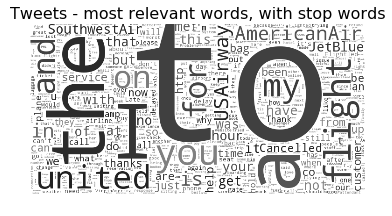

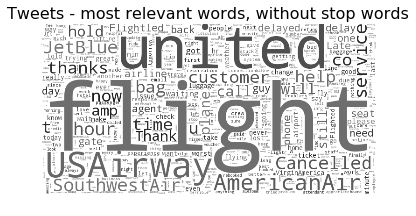

In [5]:
# All tweets (with/without stop words)
tweets = training_set['text'].tolist()
generate_cloud(raw_wordcloud, tweets, "Tweets - most relevant words, with stop words")
generate_cloud(clean_wordcloud, tweets, "Tweets - most relevant words, without stop words")

### *Tweets* positivos x *tweets* negativos

Para que possamos fazer um classificador de sentimentos positivos e negativos, é muito importante intuir se há algum tipo de separação entre as palavras presentes entre cada categoria de *tweet*. Ignorando-se as palavras vazias, as nuvens de palavras ajudam a verificar se há **termos neutros** frequentes. Ou seja: termos que aparecem em ambos os grupos.

/usr/lib/python3.5/site-packages/PIL/ImageDraw.py:99: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


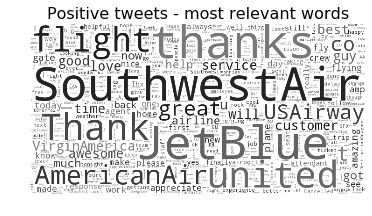

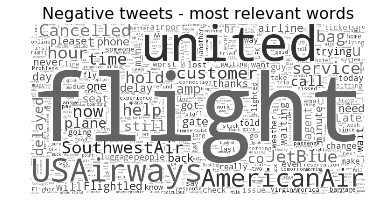

In [6]:
# Positive tweets
positive_tweets = [t for t, s in zip(training_set['text'], training_set['airline_sentiment']) if s == 1 ]
generate_cloud(clean_wordcloud, positive_tweets, "Positive tweets - most relevant words")

# Negative tweets
negative_tweets = [t for t, s in zip(training_set['text'], training_set['airline_sentiment']) if s == -1 ]
generate_cloud(clean_wordcloud, negative_tweets, "Negative tweets - most relevant words")

É interessante notar que o termo mais relevantes na nuvem inicial (*flight*, em português, "voo") possui praticamente o mesmo destaque dentre os *tweets* negativos: o que dá uma boa evidência de que a maior parte das reclamações está relacionada aos voos das companhias aéras. Na categoria negativa, também possuem relevãncia estão outros termos que seriam naturalmente esperados, tais como *cancelled* ("cancelado"), *delay* ("atraso") e *help* ("ajuda"). *Thank* e *thanks* ("obrigado") e *great* ("ótimo") aparecem muito pouco na nuvem com todos os *tweets*, mas têm grande destaque dentre os *tweets* positivos.

Considerando as companhias aéras, *United*, *USAirwais* e *AmerianAir* são as que receberam a maior parte dos *tweets* (1415, 1171 e 1117, respectivamente), e portanto apareceram mais em ambas as nuvens. Entretanto, o maior destaque ficou nos *tweets* negativos, embora elas também apareçam dentre os positivos. *JetBlue* e *SouthwestAir*, apesar de terem recebido menos *tweets* no total (822 e 701, respectivamente), apareceram majoritariamente nas referências positivas. Tendo isso em vista, a companhia aérea que está sendo referenciada no *tweet* parece ser uma informação relevante para a sua classificação.

# Filtragem de texto

Considerando uma aplicação que envolva processamento de texto, é natural realizar **filtragens** com o objetivo de simplificar (e, assim, tornar mais relevante outras informações) das palavras contidas nesse texto. Para este trabalho, foram tentadas 6 abordagens:
- **Sem filtro**: o *tweet* original, não modificado
- **Com apenas caracteres alfanuméricos**: o *tweet* com apenas letras e números ASCII
- **Sem menções a usuários**: o *tweet* sem palavras começadas por `@`
- **Sem _hashtags_**: o *tweet* sem palavras começadas por `#`
- **Com palavras lematizadas**: o *tweet* com palavras transformadas para conter apenas seus radicais
- **Com distinção entre palavras negadas**: o *tweet* modificado com a junção de *not* e o seu termo sucessor, para distinguir a versão positiva e negativa de uma mesma palavra (por exemplo, *happy* e *not happy*).

In [7]:
# Regular expressions
import re

# NLTK
from nltk.stem import WordNetLemmatizer

def noop(tweet):
    return tweet

def remove_non_alpha(tweet):
    tweet = re.sub(r"[^a-zA-Z0-9]", ' ', tweet)
    return tweet

def remove_users(tweet):
    tweet = re.sub(r"@[^ ]+", ' ', tweet)
    return tweet

def remove_hashtags(tweet):
    tweet = re.sub(r"#[^ ]+", ' ', tweet)
    return tweet

lemmatizer = WordNetLemmatizer()
def lemmatize(tweet):
    words = tweet.split()
    words = [ lemmatizer.lemmatize(w) for w in words ]
    tweet = ''.join(words)
    return tweet
    
def negation(matchobj):
    if matchobj.group(1) == "not": return 'not-'
    elif matchobj.group(1) == "cannot": return 'can not-'
    elif matchobj.group(1) == "can't": return 'can not-'
    elif matchobj.group(1) == "won't": return 'will not-'
    elif matchobj.group(1) == "n't": return ' not-'
    else: return ' '

def negate(tweet):
    tweet = re.sub(r"(not|cannot|can't|won't|n't)\s+", negation, tweet)
    return tweet

def clean(tweet):
    return negate(tweet)

Os resultados com cada tipo de filtragem estão listados na próxima seção (sobre treinamento). A versão final utilizada é a mostrada na função `clean`.

# Treinamento

Para realizar o treinamento e decidir a melhor versão testada, utiliza-se a técnica de **validação cruzada** para separar o conjunto de treinamento em um conjunto de treinamento menor e um conjunto de **validação**. O conjunto de validação pode ser aplicado para estimar a efetividade dos modelos, e para comparar o desempenho de cada um. Neste trabalho, a validação cruzada foi feita com **_10 folds_**. Cerca de $1/10$ do conjunto de treinamento foi reservado, em cada rodada, para servir para a validação, enquanto o restante ficou para treinamento. A acurácia da predição sobre o conjunto de treinamento é chamado de **erro sobre a amostra** (`E_in`). A acurácia da predição sobre o conjunto da validação é o **erro de validação** (`E_val`). Espera-se que a média dos erros de validação seja uma boa estimativa do **erro de predição** do modelo. A diferença entre `E_in` e `E_val` (levando em conta médias e desvio-padrão) dá uma estimativa da capacidade de generalização do modelo escolhido.

Na construção do modelo, variaram-se quatro fatores: o tipo de **extração de características** a **filtragem dos dados** (explicada na seção anterior), o **modelo probabilístico** utilizado na predição e a **redução de dimensionalidade** do espaço de características. Por simplicidade, o código abaixo mostra apenas a versão final utilizada para a predição do conjunto de testes. Os resultados dos outros experimentos, bem como comentários sobre os resultados, estão listados a seguir.

In [8]:
import numpy as np

# Scikit-Learning
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# NLTK
import nltk

X_train = training_set['text']
Y_train = training_set['airline_sentiment']

E_in = [0] * 10
E_val = [0] * 10

for idx, [train_index, test_index] in enumerate(KFold(X_train.size, n_folds=10)):
    print('Validation set #%d' % (idx+1))

    Xk_train, Xk_test = X_train[train_index], X_train[test_index]
    Yk_train, Yk_test = Y_train[train_index], Y_train[test_index]

    # Filtering list of words
    Xk_train_list = [ clean(w) for w in Xk_train.tolist() ]
    Xk_test_list  = [ clean(w) for w in Xk_test.tolist() ]

    bag = CountVectorizer(stop_words='english', tokenizer=nltk.word_tokenize)#, max_features=2500)
    bag.fit(Xk_train_list)
    
    train = bag.transform(Xk_train_list)
    test = bag.transform(Xk_test_list)

    logreg = LogisticRegression()
    logreg.fit(train, Yk_train)

    predK_train = logreg.predict(train)
    predK_test = logreg.predict(test)
    
    E_in[idx] = accuracy_score(Yk_train, predK_train) # logreg.score(bag_train, Yk_train)
    E_val[idx] = accuracy_score(Yk_test, predK_test) # logreg.score(bag_test, Yk_test)
    
    print('Training set accuracy : ', E_in[idx])
    print('Test set accuracy     : ', E_val[idx])
    print('')

print('E_in: ', np.average(E_in), '±', np.std(E_in))
print('E_val: ', np.average(E_val), '±', np.std(E_val))

Validation set #1
Training set accuracy :  0.979625550661
Test set accuracy     :  0.888613861386

Validation set #2
Training set accuracy :  0.978386563877
Test set accuracy     :  0.918316831683

Validation set #3
Training set accuracy :  0.978664831383
Test set accuracy     :  0.913258983891

Validation set #4
Training set accuracy :  0.97756366139
Test set accuracy     :  0.900867410161

Validation set #5
Training set accuracy :  0.979077770131
Test set accuracy     :  0.894671623296

Validation set #6
Training set accuracy :  0.979490708878
Test set accuracy     :  0.878562577447

Validation set #7
Training set accuracy :  0.977838953889
Test set accuracy     :  0.956629491945

Validation set #8
Training set accuracy :  0.978802477632
Test set accuracy     :  0.92936802974

Validation set #9
Training set accuracy :  0.979353062629
Test set accuracy     :  0.923172242875

Validation set #10
Training set accuracy :  0.978664831383
Test set accuracy     :  0.944237918216

E_in:  0.97

### Extração de características

Usar a frequência das palavras como característica para a classificação pode parecer, à primeira vista, simplista. Entretanto, a análise com as nuvens de palavras mostra que as palavras relevantes dos textos aparecem com maior frequência em uma ou outra categoria de *tweets*. Por esse motivo, um modelo de características interessante é o [**saco de palavras**](https://en.wikipedia.org/wiki/Bag-of-words_model) (*bag of wods*), que associa, a cada palavra de um dicionário, a contagem do aparecimentos dessas palavras no texto. Outro modelo alternativo, muito usado para análise de textos, é o [**Tf-Idf**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), que pondera em um único valor a frequência de aparecimento e a raridade dos termos. Ambos os tipos de extração de características foram testados nesse trabalho, obtendo-se os seguintes valores de `E_in` e `E_val`:

| Tipo de extração de características  |     E_in      |     E_val     |
| ------------------------------------ | ------------- | ------------- |
| Saco de palavras (`CountVectorizer`) | 0.977 ± 0.000 | 0.916 ± 0.024 |
| Tf-Idf (`TfIdfVectorizer`)           | 0.926 ± 0.001 | 0.914 ± 0.031 |

A acurácia da validação foi muito próxima em ambos os modelos, com um resultado ligeiramente pior para o Tf-Idf. Dada a natureza dos *tweets* e a classificação desejada (análise de sentimentos) a informação de frequência *versus* raridade agregada pelo Tf-Idf não apresenta grande vantagem para o modelo. Uma palavra classificada como positiva não é sempre positiva somente porque ela apareceu apenas uma vez. Esse tipo de resultado é mais últil para buscadores, em que um texto é um bom resultado de busca se ele contém as mesmas palavras raras que a pergunta feita.

Considerando os problemas obtidos com o Tf-Idf, o modelo de saco de palavras foi utilizado para o restante dos experimentos.

Em ambos os testes, utilizou-se a filtragem de *stop words* disponível nos modelos `CountVectorizer` e `TfIdfVectorizer` do Scikit-Learning.

**Obs:** Os resultados da tabela foram obtidos usando a regressão logística como modelo de predição e sem nenhuma filtragem.

### Filtragem

Para tentar melhorar as contagens feitas no modelo de sacos de palavras, aplicamos as diferentes filtragens mostradas na seção anterior. Os resultados de `E_in` e `E_val` foram os seguintes:

| Filtro                               |     E_in      |     E_val     |
| ------------------------------------ | ------------- | ------------- |
| Sem filtro                           | 0.977 ± 0.000 | 0.916 ± 0.024 |
| Com apenas caracteres alfanuméricos  | 0.974 ± 0.000 | 0.909 ± 0.028 |
| Sem menções a usuários               | 0.976 ± 0.000 | 0.914 ± 0.024 |
| Sem _hashtags_                       | 0.975 ± 0.000 | 0.915 ± 0.025 |
| Com palavras lematizadas             | 0.897 ± 0.001 | 0.815 ± 0.073 |
| Com distinção entre palavras negadas | 0.979 ± 0.000 | 0.915 ± 0.023 |

É interessante notar que a opção **sem filtro** foi melhor que quase todas as outras filtragens testadas. Isso pode ser explicado pelo resultado obtido quando deixaram-se apenas os caracteres alfanuméricos: os caracteres "especiais", principalmente `!`, `?` e emojis, devem agregar informações para a classificação de sentimentos. As _hashtags_ e menções não impactaram tanto na acurácia da validação, sendo as menções as mais relevantes. Esse fator pode ser explicado pela análise feita nas nuvens de palavras: as companhias "JetAir" e "SouthWestAir", quase sempre positivas, devem ter impacto na predição. A lematização foi desastrosa: tanto a acurácia na amostra quanto fora diminuíram cerca de 10%. Como os *tweets* são curtos e as palavras têm grafia abreviada e incorreta (por conta da limitação de espaço das mensagens e erros de digitação), a lematização acabou gerando sufixos errados.

Dentre as filtragens, a única que não foi mais ruim de forma conclusiva foi a que filtragem com distinção de palavras negadas (acurácia média de 0.9156 para sem filtro contra 0.9147, e desvio-padrõa de aproximadamente 0.025 em ambas as medidas). Embora não houvesse uma vantagem clara em usar esse tipo de filtragem, ela foi mantido na versão final (função `clean`), pois apresentou uma generalização melhor no modelo final submetido no Kaggle.

**Obs:** Os resultados da tabela foram obtidos usando a regressão logística como modelo de predição e o saco de palavras para extração de características

### Modelo probabilístico

Para fazer a classificação final a partir das contagens, foram testados dois modelos lineares simples: a regressão linear e a regressão logística. Os valores de `E_in` e `E_val` obtidos doram os seguintes:

| Modelo de predição                   |     E_in      |     E_val     |
| ------------------------------------ | ------------- | ------------- |
| Regressão linear                     | 0.998 ± 0.000 | 0.674 ± 0.018 |
| Regressão logística                  | 0.979 ± 0.000 | 0.915 ± 0.023 |

A regressão logística conseguiu se desempenhar muito melhor que a regressão linear - o que pode ser explicado porque a regressão logística se adequa melhor a um problema de classificação (dando um valor que pode ser interpretado como a probabilidade do teste estar numa categoria ou outra) enquanto a regressão linear se enquadra melhor para dar a intensidade dessa classificação (sendo que valores mais distantes do zero são mais próximos de uma ou outra característica).

### Redução de dimensionalidade

O último tipo de melhoria testada durante a criação do modelo foi a redução da dimensionalidade do espaço de características. A primeira possível redução é limitar o tamanho das palavras consideradas no saco de palavras. Pelos experimentos, após a retirada das palavras vazias, não há ganho em reduzir o número de palavras consideradas. De forma geral, porém, limitar o máximo para cerca de 2500 palavras não prejudicou muito a acurácia do modelo.

Outra forma de fazer uma redução de dimensionalidade é usando o PCA (*principal component analysis*). Nessa técnica, realiza-se uma mudança de base que leva a base original para a base dos componenetes principais, que representam as principais direções de espalhamento em cada dimensão. O PCA pode ser calculado por meio da SVD (*singular value decomposition*), que fornece os vetores necessários para a mudança de base. Embora essa mudança parecesse uma boa ideia, o custo de calcular a SVD para mais de 8000 dimensões (e mesmo para 2500). Por essa razão, não foi possível fazer essa redução de dimensionalidade.

In [9]:
X_test = test_set['text']

X_train_list = [ clean(w) for w in X_train.tolist() ]
X_test_list = [ clean(w) for w in X_test.tolist() ]

bag = CountVectorizer(stop_words='english', tokenizer=nltk.word_tokenize)
bag.fit(X_train_list)

train = bag.transform(X_train_list)
test  = bag.transform(X_test_list)

logreg = LogisticRegression()
logreg.fit(train, Y_train)

pred = logreg.predict(test)

test_set['airline_sentiment'] = pd.Series(pred)

kaggle = test_set[['id', 'airline_sentiment']]
kaggle.to_csv('result.csv', index=False, header=True)

print(len(kaggle))

3469
